In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:35 - loss: 0.0351 - STD: 2.5430e-04 - MAE: 0.1802

 12/632 [..............................] - ETA: 2s - loss: 0.0205 - STD: 6.2854e-04 - MAE: 0.1058   

 23/632 [>.............................] - ETA: 2s - loss: 0.0171 - STD: 0.0010 - MAE: 0.0873    

 33/632 [>.............................] - ETA: 2s - loss: 0.0158 - STD: 0.0016 - MAE: 0.0848

 45/632 [=>............................] - ETA: 2s - loss: 0.0148 - STD: 0.0029 - MAE: 0.0802

 57/632 [=>............................] - ETA: 2s - loss: 0.0138 - STD: 0.0067 - MAE: 0.0761

 69/632 [==>...........................] - ETA: 2s - loss: 0.0125 - STD: 0.0165 - MAE: 0.0713

 81/632 [==>...........................] - ETA: 2s - loss: 0.0112 - STD: 0.0268 - MAE: 0.0666

 93/632 [===>..........................] - ETA: 2s - loss: 0.0102 - STD: 0.0360 - MAE: 0.0628

105/632 [===>..........................] - ETA: 2s - loss: 0.0094 - STD: 0.0431 - MAE: 0.0597

115/632 [====>.........................] - ETA: 2s - loss: 0.0089 - STD: 0.0479 - MAE: 0.0576

125/632 [====>.........................] - ETA: 2s - loss: 0.0084 - STD: 0.0520 - MAE: 0.0558

135/632 [=====>........................] - ETA: 2s - loss: 0.0080 - STD: 0.0554 - MAE: 0.0542

145/632 [=====>........................] - ETA: 2s - loss: 0.0076 - STD: 0.0585 - MAE: 0.0527

156/632 [======>.......................] - ETA: 2s - loss: 0.0072 - STD: 0.0616 - MAE: 0.0513

167/632 [======>.......................] - ETA: 2s - loss: 0.0069 - STD: 0.0643 - MAE: 0.0500

177/632 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0663 - MAE: 0.0489

187/632 [=======>......................] - ETA: 2s - loss: 0.0064 - STD: 0.0683 - MAE: 0.0480

197/632 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0699 - MAE: 0.0471

207/632 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0714 - MAE: 0.0463

217/632 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0728 - MAE: 0.0456

227/632 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0742 - MAE: 0.0449

237/632 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0754 - MAE: 0.0442

248/632 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0436

260/632 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0778 - MAE: 0.0429

272/632 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0423

284/632 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0417

296/632 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0412

307/632 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0408

318/632 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0404

330/632 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0399

342/632 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0840 - MAE: 0.0395

354/632 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0391

365/632 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0852 - MAE: 0.0388

377/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0859 - MAE: 0.0385

389/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0864 - MAE: 0.0382

401/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0870 - MAE: 0.0379

414/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0875 - MAE: 0.0376

427/632 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0881 - MAE: 0.0374

440/632 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0885 - MAE: 0.0371

453/632 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0890 - MAE: 0.0369

466/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0894 - MAE: 0.0366

477/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0898 - MAE: 0.0364

487/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0901 - MAE: 0.0362

497/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0903 - MAE: 0.0361

508/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0906 - MAE: 0.0359

513/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0907 - MAE: 0.0358

523/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0909 - MAE: 0.0357

533/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0912 - MAE: 0.0355

543/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0354

553/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0352

562/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0920 - MAE: 0.0351

572/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0922 - MAE: 0.0350

582/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0349

593/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0347

605/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0346

617/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0931 - MAE: 0.0345

629/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0343

632/632 [==============================] - 5s 7ms/step - loss: 0.0031 - STD: 0.0934 - MAE: 0.0343 - val_loss: 0.0019 - val_STD: 0.0798 - val_MAE: 0.0307


Epoch 2/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0013 - STD: 0.1163 - MAE: 0.0258

 12/632 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0276 

 24/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0279

 36/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0280

 49/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0280

 61/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

 72/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

 82/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

 94/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

106/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

119/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

131/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

144/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

156/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

168/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

179/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

189/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

199/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

209/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

219/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

229/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

239/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0272

251/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

262/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

272/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

282/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

293/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

304/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

316/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

328/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

339/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

349/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

360/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

370/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

380/632 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

391/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

402/632 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

412/632 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

423/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

435/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

446/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

457/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

467/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

479/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

489/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

500/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

510/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

521/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

533/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

545/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

556/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

568/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

580/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

590/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

601/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

612/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

624/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

632/632 [==============================] - 3s 5ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272 - val_loss: 0.0016 - val_STD: 0.0787 - val_MAE: 0.0289


Epoch 3/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0298

 12/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268 

 22/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

 32/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

 42/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

 52/632 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0267

 62/632 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

 72/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

 82/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

 94/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

106/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

118/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

128/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

138/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

148/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

158/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

168/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

178/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

188/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

198/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

208/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

218/632 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

228/632 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

238/632 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

248/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

258/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

268/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

278/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

288/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

299/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

309/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

319/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

330/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

342/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

354/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

366/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

378/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

390/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

402/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

415/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

428/632 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

441/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

453/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

465/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

478/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

490/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

502/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

515/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

527/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

540/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

552/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

564/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

576/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

589/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

602/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

615/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

628/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.0809 - val_MAE: 0.0284


Epoch 4/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0014 - STD: 0.1142 - MAE: 0.0258

 13/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0260 

 25/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

 36/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

 46/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 57/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0259

 68/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

 78/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 88/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

 99/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

110/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

121/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

132/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

144/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

157/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

170/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

183/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

196/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

208/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

220/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

231/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

241/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

251/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

261/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

271/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

284/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

297/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

309/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

321/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

333/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

345/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

357/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

367/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

377/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

387/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

398/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

408/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

418/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

429/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

440/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

451/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

462/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

473/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

484/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

495/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

506/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

518/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

530/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

542/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

554/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

566/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

578/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

590/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

602/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

612/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

622/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

632/632 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0793 - val_MAE: 0.0280


Epoch 5/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0013 - STD: 0.1029 - MAE: 0.0252

 12/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1042 - MAE: 0.0248 

 23/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

 35/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0257

 46/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0256

 57/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0256

 68/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0257

 78/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

 88/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

 98/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

110/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

122/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

134/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

146/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

158/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

170/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

182/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

194/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

207/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

219/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

231/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

244/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

257/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

270/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

283/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

295/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

307/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

319/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

331/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

343/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

355/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

367/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

378/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

390/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

402/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

414/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

426/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

438/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

449/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

460/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

472/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

484/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

497/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

509/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

521/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

533/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

545/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

557/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

569/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

581/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

594/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

606/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

618/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

630/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0018 - val_STD: 0.0847 - val_MAE: 0.0289


Epoch 6/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1106 - MAE: 0.0241

 12/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0264 

 24/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0261

 35/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

 47/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

 59/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

 71/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

 83/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

 95/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

107/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

119/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

131/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

144/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

157/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

170/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

183/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

196/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

209/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

221/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

232/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

244/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

257/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

269/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

281/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

293/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

305/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

317/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

330/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

342/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

354/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

366/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

378/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

390/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

401/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

413/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

426/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

438/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

450/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

462/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

474/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

485/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

496/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

506/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

517/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

528/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

539/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

551/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

563/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

576/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

589/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

602/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

615/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

628/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251 - val_loss: 0.0015 - val_STD: 0.0855 - val_MAE: 0.0267


Epoch 7/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1104 - MAE: 0.0237

 14/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0248 

 27/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0250

 40/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

 52/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0246

 64/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0245

 76/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0245

 89/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0244

101/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0244

114/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0244

126/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

138/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0246

149/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

159/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

169/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

180/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

192/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

204/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

216/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

228/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

240/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

251/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

263/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

276/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

289/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

301/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

313/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

325/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0245

337/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

349/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

361/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

373/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

385/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

398/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

411/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

424/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

437/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

449/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

461/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

473/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

486/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

498/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

510/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

522/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

534/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

546/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

558/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

571/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

584/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

597/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

609/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

622/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246 - val_loss: 0.0014 - val_STD: 0.0824 - val_MAE: 0.0260


Epoch 8/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0013 - STD: 0.0980 - MAE: 0.0249

 11/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0238 

 21/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0240

 31/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0240

 41/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

 52/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0240

 64/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

 76/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0240

 88/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

 98/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0241

108/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0242

119/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0241

130/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0242

141/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0242

153/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0241

165/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

176/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0241

186/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0241

196/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

206/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

216/632 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

227/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

239/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

251/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

263/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

276/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

287/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

297/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

307/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

318/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

329/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

339/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

349/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

359/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

370/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

382/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

394/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

406/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

418/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

430/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

443/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

455/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

467/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

479/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

490/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

500/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

510/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

521/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

531/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

541/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

552/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

563/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

573/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

583/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

593/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0240

603/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

613/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

624/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240 - val_loss: 0.0018 - val_STD: 0.0898 - val_MAE: 0.0289


Epoch 9/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0242

 11/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1062 - MAE: 0.0233 

 22/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

 32/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

 43/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

 54/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

 64/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

 75/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

 87/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

 98/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

109/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

120/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

131/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

142/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0238

154/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

167/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

179/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

190/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

200/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

210/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

221/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

231/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

242/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

253/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

264/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

275/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

285/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

296/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0237

307/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

319/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

331/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

343/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

355/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

367/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

379/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

391/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

402/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

412/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

424/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

435/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

446/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

458/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

470/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0236

482/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

494/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

506/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

518/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

530/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

542/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

554/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

566/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0236

578/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

590/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

602/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

614/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

626/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236 - val_loss: 0.0016 - val_STD: 0.0841 - val_MAE: 0.0270


Epoch 10/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.1048 - MAE: 0.0225

 11/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1086 - MAE: 0.0231 

 22/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0230

 34/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0230

 46/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0231

 58/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

 70/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0233

 82/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0234

 93/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0234

104/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0233

115/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0233

125/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0233

135/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

145/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

155/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

165/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

177/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

189/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

201/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0232

213/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

225/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

237/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

248/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

258/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

269/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

281/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0232

293/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

304/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

314/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

324/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

334/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

344/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

356/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

368/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

380/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

391/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

402/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

412/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

422/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

432/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

443/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

454/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

465/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

476/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

487/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

499/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0231

510/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

521/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0231

531/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

541/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

552/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

563/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

574/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

584/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

595/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

607/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

619/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

631/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231 - val_loss: 0.0020 - val_STD: 0.0864 - val_MAE: 0.0303


Epoch 11/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0237

 11/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0236 

 22/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1091 - MAE: 0.0239

 32/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1086 - MAE: 0.0238

 42/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1078 - MAE: 0.0238

 52/632 [=>............................] - ETA: 3s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0238

 61/632 [=>............................] - ETA: 3s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0235

 71/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

 81/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

 91/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

101/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

111/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

121/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

131/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

141/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

151/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

161/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

171/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

181/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

191/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

200/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

210/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

220/632 [=========>....................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

229/632 [=========>....................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

239/632 [==========>...................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0230

248/632 [==========>...................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

258/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

269/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

279/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

289/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

299/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

309/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

319/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

329/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

339/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

349/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

359/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

369/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

379/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

390/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

401/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

411/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

421/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

431/632 [===================>..........] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

443/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

455/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

467/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

479/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

491/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

503/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

515/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

527/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

539/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

550/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

561/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

572/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

584/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

596/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

608/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

619/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

631/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230 - val_loss: 0.0023 - val_STD: 0.0865 - val_MAE: 0.0324


Epoch 12/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0012 - STD: 0.1027 - MAE: 0.0241

 10/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0229 

 20/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0229

 30/632 [>.............................] - ETA: 3s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0227

 40/632 [>.............................] - ETA: 3s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0227

 50/632 [=>............................] - ETA: 3s - loss: 0.0010 - STD: 0.1072 - MAE: 0.0226

 61/632 [=>............................] - ETA: 3s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

 71/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

 81/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0226

 91/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0225

101/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

112/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

122/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

133/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

143/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

153/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

163/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

173/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

184/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

196/632 [========>.....................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

208/632 [========>.....................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

221/632 [=========>....................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

234/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

247/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

258/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

270/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

282/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

294/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

306/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

316/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

326/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

336/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

346/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

357/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1074 - MAE: 0.0227

367/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1074 - MAE: 0.0227

377/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

387/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

398/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

409/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

420/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

431/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

441/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

451/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

461/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

471/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

482/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

494/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

506/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

518/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0226

530/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

542/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

554/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

566/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

577/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0227

588/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0227

598/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

609/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

622/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227 - val_loss: 0.0018 - val_STD: 0.0860 - val_MAE: 0.0282


Epoch 13/10000


  1/632 [..............................] - ETA: 11s - loss: 9.4141e-04 - STD: 0.1028 - MAE: 0.0216

 12/632 [..............................] - ETA: 2s - loss: 9.9690e-04 - STD: 0.1057 - MAE: 0.0222 

 23/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225    

 33/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

 43/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0226

 53/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0227

 64/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

 74/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

 84/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0224

 94/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

105/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

115/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

126/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0224

138/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

150/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

162/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

174/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

186/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

198/632 [========>.....................] - ETA: 2s - loss: 0.0010 - STD: 0.1075 - MAE: 0.0225

210/632 [========>.....................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

222/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

234/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

246/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

258/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

270/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

282/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

294/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

306/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

318/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

330/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

343/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

356/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

368/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

380/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

392/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

404/632 [==================>...........] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

417/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

430/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

442/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

454/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

467/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

479/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

491/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

503/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

515/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

527/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0224

538/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

548/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

559/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

570/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223

582/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

594/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

606/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

617/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

629/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

632/632 [==============================] - 3s 5ms/step - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223 - val_loss: 0.0019 - val_STD: 0.0889 - val_MAE: 0.0304


Epoch 14/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0012 - STD: 0.1042 - MAE: 0.0242

 12/632 [..............................] - ETA: 2s - loss: 0.0010 - STD: 0.1058 - MAE: 0.0226 

 24/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0224

 36/632 [>.............................] - ETA: 2s - loss: 9.9915e-04 - STD: 0.1065 - MAE: 0.0223

 49/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0223    

 62/632 [=>............................] - ETA: 2s - loss: 9.9874e-04 - STD: 0.1073 - MAE: 0.0222

 74/632 [==>...........................] - ETA: 2s - loss: 9.9406e-04 - STD: 0.1073 - MAE: 0.0222

 86/632 [===>..........................] - ETA: 2s - loss: 9.8789e-04 - STD: 0.1075 - MAE: 0.0221

 98/632 [===>..........................] - ETA: 2s - loss: 9.8669e-04 - STD: 0.1071 - MAE: 0.0221

110/632 [====>.........................] - ETA: 2s - loss: 9.9115e-04 - STD: 0.1070 - MAE: 0.0221

122/632 [====>.........................] - ETA: 2s - loss: 9.9259e-04 - STD: 0.1068 - MAE: 0.0222

134/632 [=====>........................] - ETA: 2s - loss: 9.9124e-04 - STD: 0.1069 - MAE: 0.0221

146/632 [=====>........................] - ETA: 2s - loss: 9.8987e-04 - STD: 0.1071 - MAE: 0.0221

158/632 [======>.......................] - ETA: 2s - loss: 9.9092e-04 - STD: 0.1072 - MAE: 0.0221

170/632 [=======>......................] - ETA: 1s - loss: 9.9065e-04 - STD: 0.1071 - MAE: 0.0221

182/632 [=======>......................] - ETA: 1s - loss: 9.9019e-04 - STD: 0.1072 - MAE: 0.0221

194/632 [========>.....................] - ETA: 1s - loss: 9.9217e-04 - STD: 0.1070 - MAE: 0.0221

206/632 [========>.....................] - ETA: 1s - loss: 9.9008e-04 - STD: 0.1070 - MAE: 0.0221

218/632 [=========>....................] - ETA: 1s - loss: 9.8835e-04 - STD: 0.1071 - MAE: 0.0221

229/632 [=========>....................] - ETA: 1s - loss: 9.8810e-04 - STD: 0.1072 - MAE: 0.0221

241/632 [==========>...................] - ETA: 1s - loss: 9.8955e-04 - STD: 0.1075 - MAE: 0.0221

253/632 [===========>..................] - ETA: 1s - loss: 9.9077e-04 - STD: 0.1075 - MAE: 0.0221

265/632 [===========>..................] - ETA: 1s - loss: 9.8978e-04 - STD: 0.1075 - MAE: 0.0221

278/632 [============>.................] - ETA: 1s - loss: 9.8913e-04 - STD: 0.1076 - MAE: 0.0221

290/632 [============>.................] - ETA: 1s - loss: 9.9130e-04 - STD: 0.1077 - MAE: 0.0221

302/632 [=============>................] - ETA: 1s - loss: 9.8962e-04 - STD: 0.1079 - MAE: 0.0221

314/632 [=============>................] - ETA: 1s - loss: 9.8904e-04 - STD: 0.1080 - MAE: 0.0221

326/632 [==============>...............] - ETA: 1s - loss: 9.8772e-04 - STD: 0.1080 - MAE: 0.0221

338/632 [===============>..............] - ETA: 1s - loss: 9.8892e-04 - STD: 0.1081 - MAE: 0.0221

350/632 [===============>..............] - ETA: 1s - loss: 9.9025e-04 - STD: 0.1080 - MAE: 0.0221

362/632 [================>.............] - ETA: 1s - loss: 9.8982e-04 - STD: 0.1080 - MAE: 0.0221

375/632 [================>.............] - ETA: 1s - loss: 9.8847e-04 - STD: 0.1079 - MAE: 0.0221

387/632 [=================>............] - ETA: 1s - loss: 9.8966e-04 - STD: 0.1079 - MAE: 0.0221

399/632 [=================>............] - ETA: 1s - loss: 9.8904e-04 - STD: 0.1080 - MAE: 0.0221

412/632 [==================>...........] - ETA: 0s - loss: 9.8815e-04 - STD: 0.1080 - MAE: 0.0221

424/632 [===================>..........] - ETA: 0s - loss: 9.8805e-04 - STD: 0.1080 - MAE: 0.0221

436/632 [===================>..........] - ETA: 0s - loss: 9.8859e-04 - STD: 0.1081 - MAE: 0.0221

449/632 [====================>.........] - ETA: 0s - loss: 9.8787e-04 - STD: 0.1081 - MAE: 0.0221

462/632 [====================>.........] - ETA: 0s - loss: 9.8821e-04 - STD: 0.1081 - MAE: 0.0221

475/632 [=====================>........] - ETA: 0s - loss: 9.8869e-04 - STD: 0.1082 - MAE: 0.0221

488/632 [======================>.......] - ETA: 0s - loss: 9.8792e-04 - STD: 0.1081 - MAE: 0.0221

500/632 [======================>.......] - ETA: 0s - loss: 9.8943e-04 - STD: 0.1081 - MAE: 0.0221

512/632 [=======================>......] - ETA: 0s - loss: 9.8843e-04 - STD: 0.1080 - MAE: 0.0221

524/632 [=======================>......] - ETA: 0s - loss: 9.8865e-04 - STD: 0.1080 - MAE: 0.0221

536/632 [========================>.....] - ETA: 0s - loss: 9.8833e-04 - STD: 0.1080 - MAE: 0.0221

548/632 [=========================>....] - ETA: 0s - loss: 9.8816e-04 - STD: 0.1080 - MAE: 0.0221

560/632 [=========================>....] - ETA: 0s - loss: 9.8830e-04 - STD: 0.1080 - MAE: 0.0221

572/632 [==========================>...] - ETA: 0s - loss: 9.8854e-04 - STD: 0.1080 - MAE: 0.0221

584/632 [==========================>...] - ETA: 0s - loss: 9.8862e-04 - STD: 0.1080 - MAE: 0.0221

595/632 [===========================>..] - ETA: 0s - loss: 9.8860e-04 - STD: 0.1080 - MAE: 0.0221

607/632 [===========================>..] - ETA: 0s - loss: 9.8773e-04 - STD: 0.1079 - MAE: 0.0221

619/632 [============================>.] - ETA: 0s - loss: 9.8694e-04 - STD: 0.1079 - MAE: 0.0221

632/632 [==============================] - ETA: 0s - loss: 9.8691e-04 - STD: 0.1079 - MAE: 0.0221

632/632 [==============================] - 3s 5ms/step - loss: 9.8691e-04 - STD: 0.1079 - MAE: 0.0221 - val_loss: 0.0021 - val_STD: 0.0866 - val_MAE: 0.0297


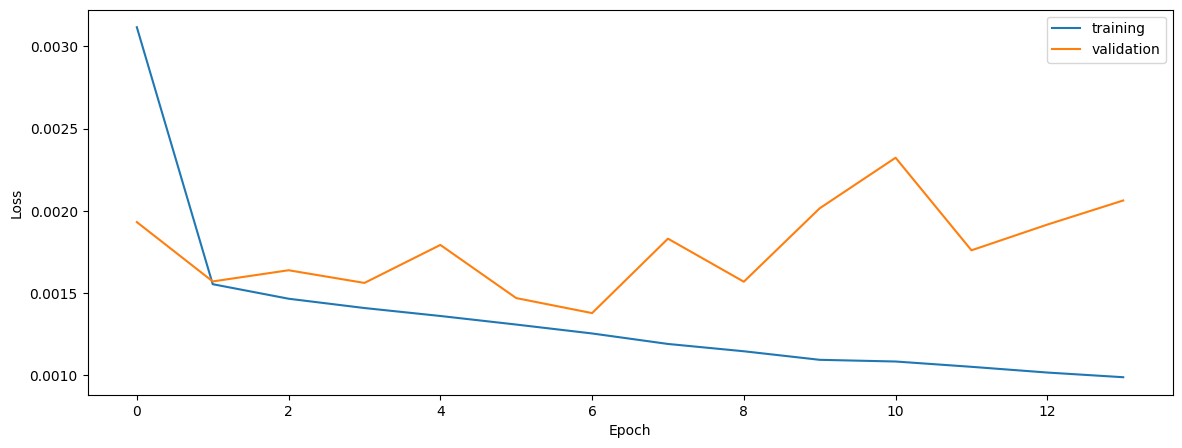

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9523834475338602
0.9593420242434563
0.946834891831719


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9512338825210165
0.9552640479485074
0.9505483255014441


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9567984540612215
0.9562811895977129
0.9612383966541254


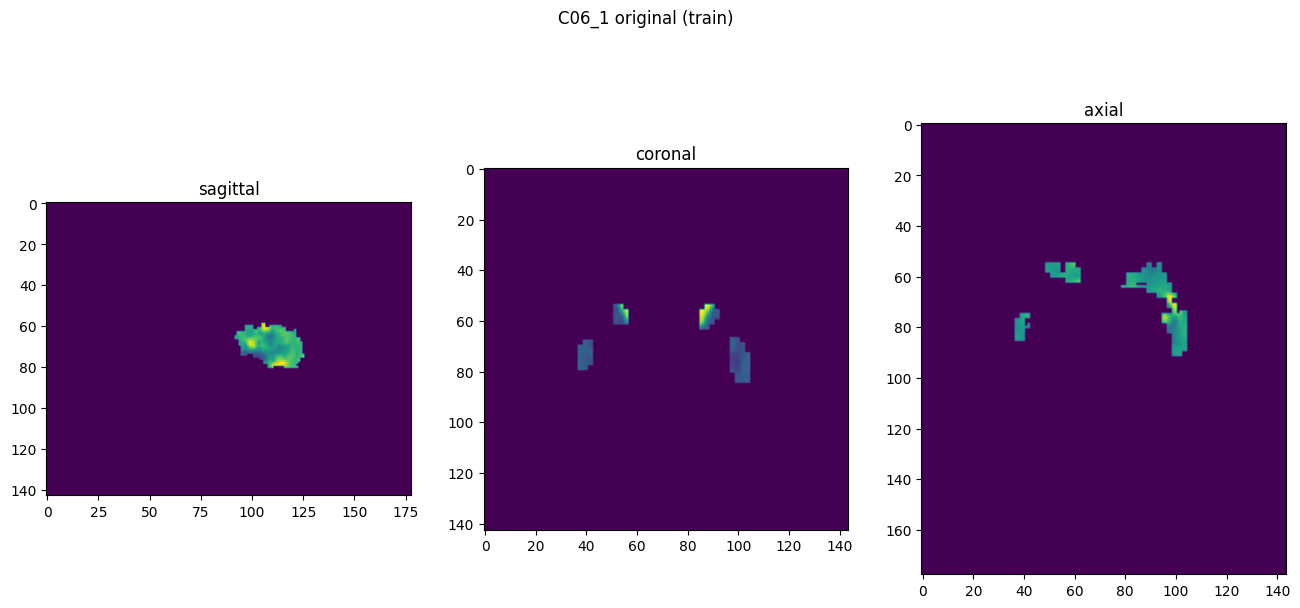

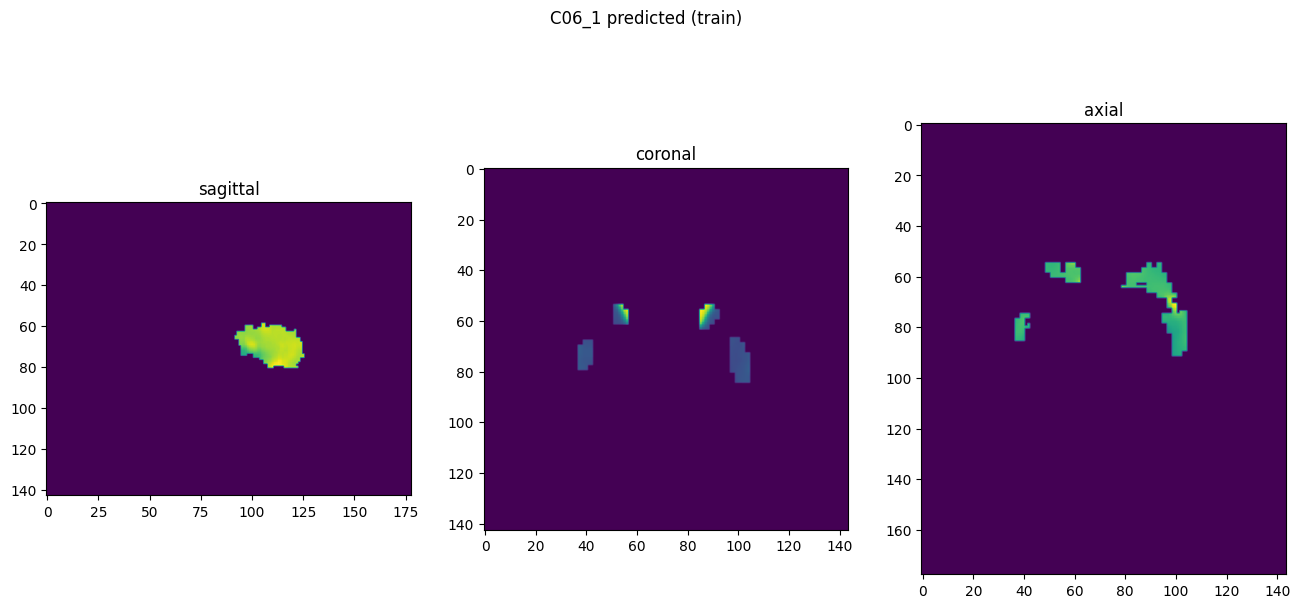

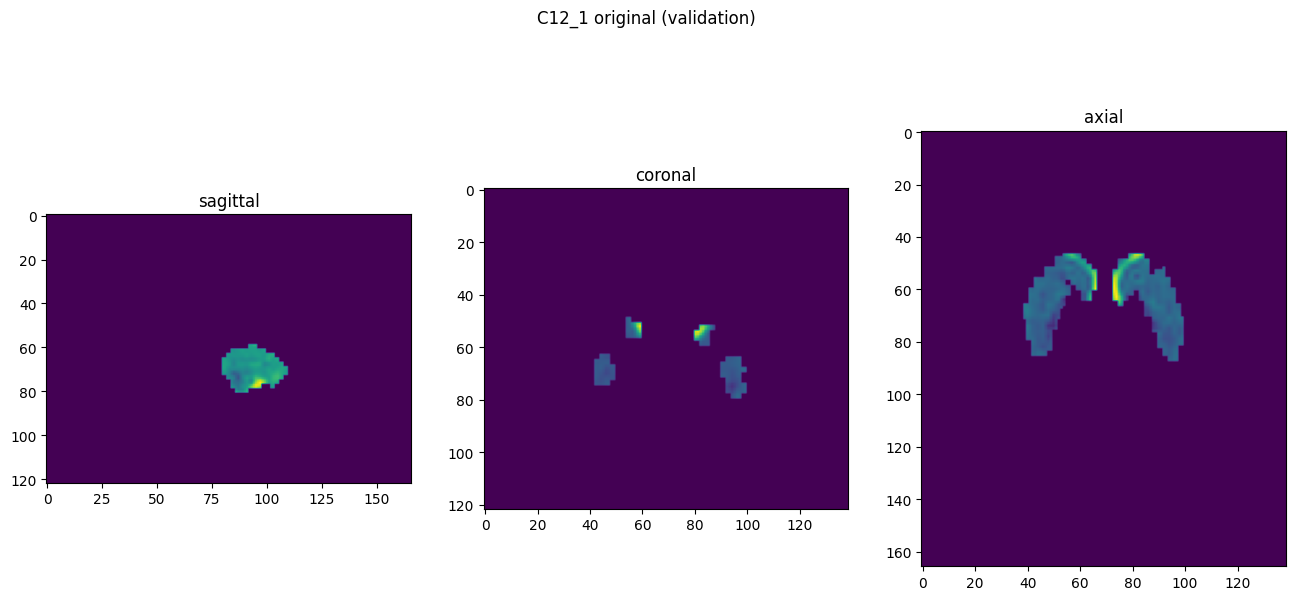

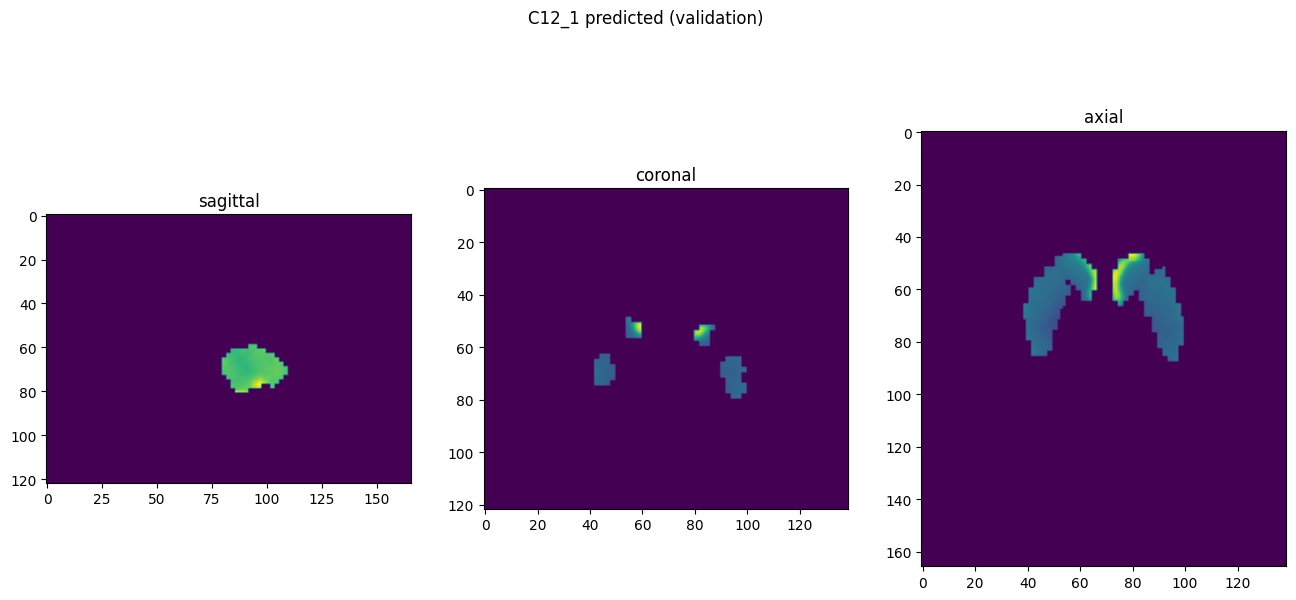

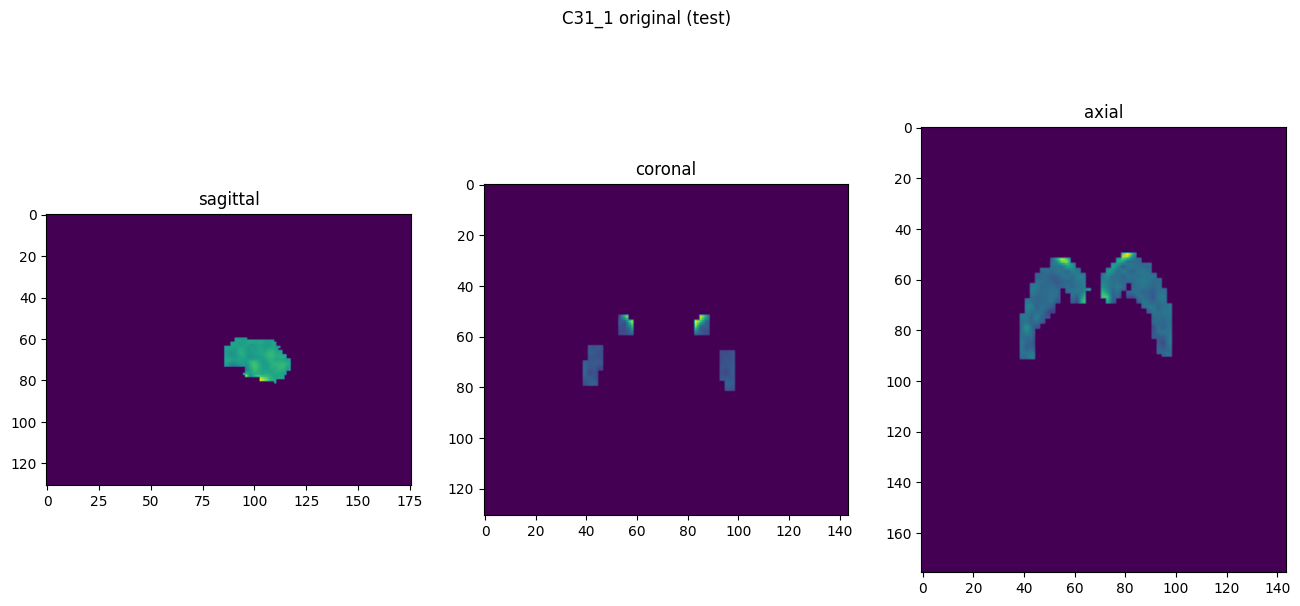

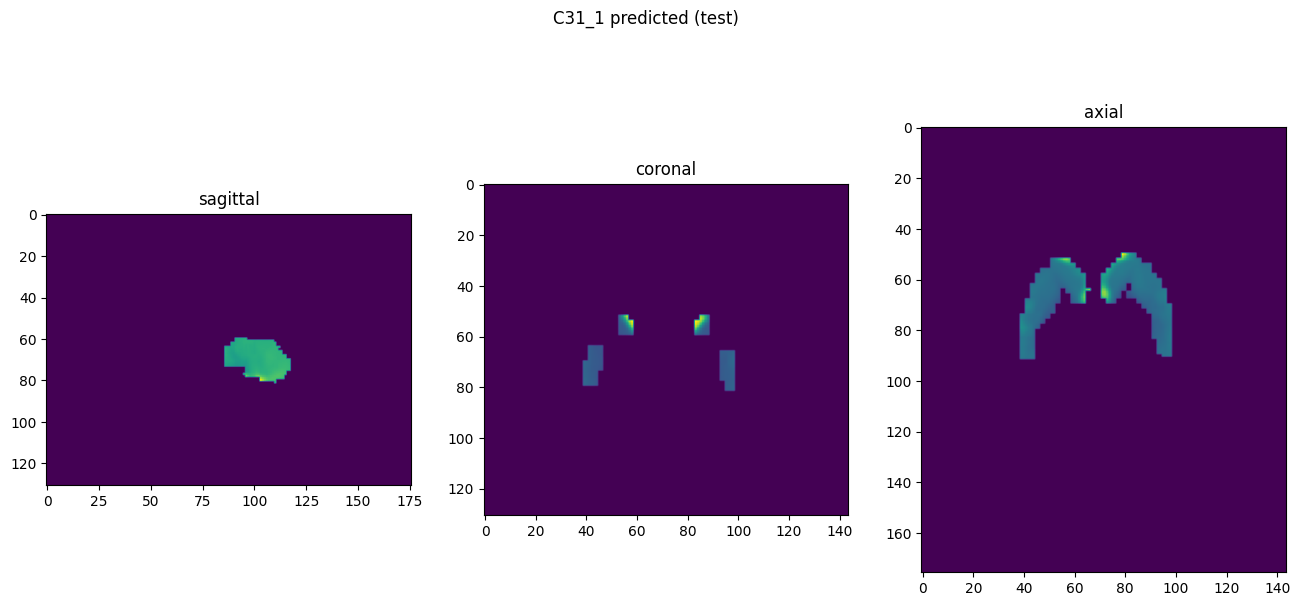

In [10]:
showResults(model, gen, threshold=None, background=False)